In [1]:
from pipeline import Pipeline
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="Pikurrot/yolo11n-licenseplates", filename="yolo11n_licenseplates.pt")
pipeline = Pipeline(model_path)

/home/eric/miniconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cuda


In [2]:
segments = pipeline("images/reduced/")


image 1/12 /media/eric/D/repos/ANPR-GIA/images/reduced/0.jpg: 384x640 1 license_plate, 41.1ms
image 2/12 /media/eric/D/repos/ANPR-GIA/images/reduced/1.jpg: 384x640 1 license_plate, 14.3ms
image 3/12 /media/eric/D/repos/ANPR-GIA/images/reduced/10.jpeg: 480x640 1 license_plate, 32.4ms
image 4/12 /media/eric/D/repos/ANPR-GIA/images/reduced/11.jpeg: 640x480 1 license_plate, 32.0ms
image 5/12 /media/eric/D/repos/ANPR-GIA/images/reduced/2.jpg: 288x640 1 license_plate, 35.3ms
image 6/12 /media/eric/D/repos/ANPR-GIA/images/reduced/3.jpg: 288x640 1 license_plate, 13.0ms
image 7/12 /media/eric/D/repos/ANPR-GIA/images/reduced/4.jpg: 288x640 1 license_plate, 12.9ms
image 8/12 /media/eric/D/repos/ANPR-GIA/images/reduced/5.jpg: 384x640 1 license_plate, 14.9ms
image 9/12 /media/eric/D/repos/ANPR-GIA/images/reduced/6.jpg: 480x640 1 license_plate, 9.5ms
image 10/12 /media/eric/D/repos/ANPR-GIA/images/reduced/7.jpg: 640x640 1 license_plate, 11.8ms
image 11/12 /media/eric/D/repos/ANPR-GIA/images/reduced

In [14]:
from PIL import Image
import os
import matplotlib.pyplot as plt

filenames = os.listdir("images/reduced/")
orig_images = [Image.open(f"images/reduced/{filename}") for filename in filenames]

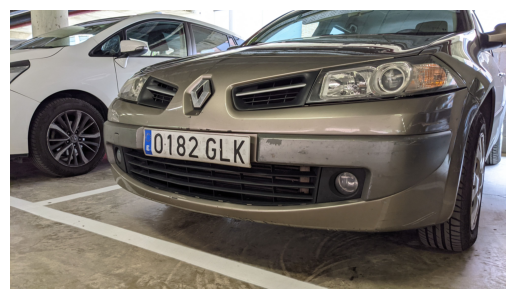

In [31]:
i = 1
plt.imshow(orig_images[i])
plt.axis("off")
plt.show()

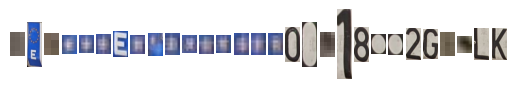

In [32]:
segments0 = segments[i][0]
fig, ax = plt.subplots(1, len(segments0))
for s, segment in enumerate(segments0):
	ax[s].imshow(segment)
	ax[s].axis("off")
plt.show()